# CRAN Distribution of GitHub Packages

We study the CRAN distribution of GitHub R Packages. In particular, we focus on a survival analysis based on the time needed for a R package on GitHub to appear on CRAN. 

In [1]:
import pandas
from matplotlib import pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf')

cran_release = pandas.DataFrame.from_csv('../data/cran-packages-150601.csv', index_col=None)
data = pandas.DataFrame.from_csv('../data/github-cran-bioc-alldata-150420.csv', index_col=None)

In [2]:
github = data.query('Source == "github"').sort('Date').drop_duplicates('Package').set_index('Package')
github.rename(columns={'Date': 'github'}, inplace=True)

In [3]:
cran = cran_release.sort('mtime').drop_duplicates('package').rename(columns={'package': 'Package', 'mtime': 'cran'})[['Package', 'cran']].set_index('Package')

In [4]:
# Keep GitHub packages
packages = github.join(cran, how='left')

# Fix datetimes
packages['github'] = pandas.to_datetime(packages['github']).astype('datetime64[ns]')
packages['cran'] = pandas.to_datetime(packages['cran']).astype('datetime64[ns]')

# Compute delta & sort (cosmetic)
packages['elapsed'] = packages['cran'] - packages['github']
packages.sort('elapsed', inplace=True)

# In days
packages['elapsed'] = packages['elapsed'] / pandas.np.timedelta64(1, 'D')

# Do GitHub packages have a CRAN dependency?
packages.fillna({'Depends': '', 'Imports': ''}, inplace=True)
cran_deps = lambda r: any((p in cran.index for p in 
  [x.strip() for x in r['Depends'].split(' ') if len(x.strip())>0] + [x.strip() for x in r['Imports'].split(' ') if len(x.strip())>0]
))
packages['cran_deps'] = packages.apply(cran_deps, axis=1)

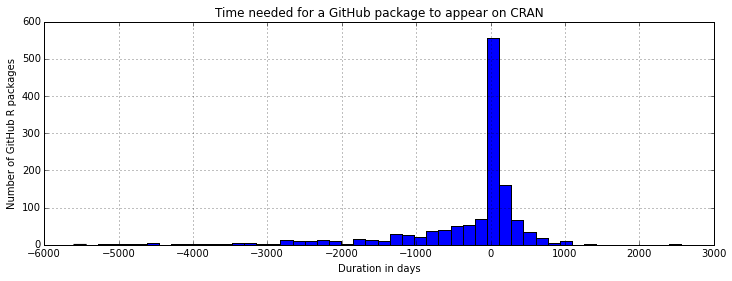

In [5]:
ax = packages['elapsed'].plot(kind='hist', bins=50)
ax.set_title('Time needed for a GitHub package to appear on CRAN')
ax.figure.set_size_inches(12, 4)
ax.set_xlabel('Duration in days')
ax.set_ylabel('Number of GitHub R packages')

Which are those outliers?

In [6]:
packages.sort('elapsed', ascending=False)[:5][['github', 'cran', 'elapsed']]

,github,cran,elapsed
Package,,,
emu,2001-02-08 23:38:11,2008-02-16 14:56:40,2563.637836
xoi,2009-04-28 17:44:42,2012-10-15 17:30:08,1265.989884
broman,2009-04-28 18:04:00,2012-10-15 16:29:09,1265.934132
qtutils,2009-06-19 18:27:47,2012-05-09 15:25:46,1054.873600
qiimer,2010-11-22 15:29:41,2013-10-05 23:12:15,1048.321227


Let's prepare the data for a survival analysis. 

In [7]:
import lifelines

Using pure Python version of concordance index. 
You can speed this up 100x by compiling the Fortran code with:
>>> python setup.py build_ext --inplace


In [8]:
survival = packages.copy()

# Remove packages that were first on CRAN
survival = survival.fillna(pandas.datetime(2050,1,1)).query('github < cran').replace(pandas.datetime(2050,1,1), pandas.np.nan)

# Observed packages
survival['observed'] = survival['elapsed'].apply(lambda x: not pandas.np.isnan(x))

# Censored packages (NaN) are set to now
survival['elapsed'] = survival.apply(lambda r: r['elapsed'] if not pandas.np.isnan(r['elapsed']) 
               else (pandas.datetime.now() - r['github']) / pandas.np.timedelta64(1, 'D'), axis=1)

print len(packages), len(survival), len(survival[survival['observed']])

5730 5225 803


All: 5225 items, 803 observed
Without outliers: 5222 items, 800 observed
Version >= 1: 1740 items, 219 observed
Version < 1: 3485 items, 584 observed
With CRAN dependencies: 2844 items, 495 observed
Without CRAN dependencies: 2381 items, 308 observed


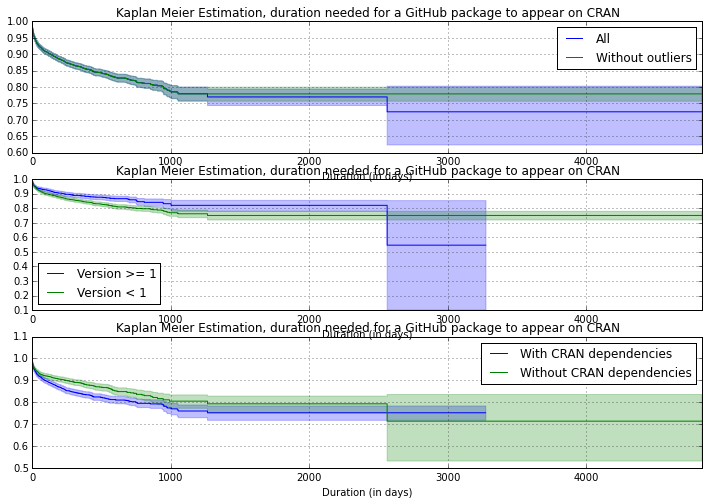

In [9]:
kmf = lifelines.KaplanMeierFitter() 

plot_groups = [
    [
        {'label': 'All', 'df': survival.query('observed or not observed')}, 
        {'label': 'Without outliers', 'df': survival.query('observed == False or elapsed < 1200')},
    ],[
        {'label': 'Version >= 1', 'df': survival[survival['Version'].str[0] >= '1']},
        {'label': 'Version < 1', 'df': survival[survival['Version'].str[0] < '1']},
    ],[
        {'label': 'With CRAN dependencies', 'df': survival.query('cran_deps == True')},
        {'label': 'Without CRAN dependencies', 'df': survival.query('cran_deps == False')},
    ], 
]

for i, group in enumerate(plot_groups):
    ax = plt.subplot(len(plot_groups), 1, i+1)
    for cond in group:
        print '{}: {} items, {} observed'.format(cond['label'], len(cond['df']), len(cond['df'].query('observed == True')))
        kmf.fit(cond['df']['elapsed'], event_observed=cond['df']['observed'], label=cond['label'])
        ax = kmf.plot(ax=ax)
    ax.set_title('Kaplan Meier Estimation, duration needed for a GitHub package to appear on CRAN')
    ax.figure.set_size_inches(12, 8)
    ax.set_xlabel('Duration (in days)')

